In [1]:
!pip install gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=9681 sha256=fe39543d09f204c90d04e3205a9ec9116fea6ab8fc0ab47c3822ddc72bb5c33d
  Stored in directory: /root/.cache/pip/wheels/ba/e0/7e/726e872a53f7358b4b96a9975b04e98113b005cd8609a63abc
Successfully built gdown


In [2]:
!gdown https://drive.google.com/uc?id=1-7z0lFddFDcy97On7vO5MlucFUiFJYi1

Downloading...
From: https://drive.google.com/uc?id=1-7z0lFddFDcy97On7vO5MlucFUiFJYi1
To: /kaggle/working/lab_img.pt
107MB [00:00, 146MB/s]  


In [10]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [3]:
# load data
data = torch.load('lab_img.pt')

In [8]:
# set device
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
print('device', device)

device cuda


In [11]:
# load resnet101
model = models.resnet101(pretrained=True)

# use cuda if available
if torch.cuda.is_available():
    model.cuda()

model = model.eval()

print('use cuda', torch.cuda.is_available())

use cuda True


In [12]:
# test clean accuracy
total = 0
correct = 0
for d in data:
   lab, img = d
   lab, img = lab.cuda(), img.cuda()
   output = model(img)
   _, pre = torch.max(output.data, 1)
   total += 1
   if pre == lab:
       correct += 1
print('clean accuracy', correct/total)

clean accuracy 1.0


In [13]:
# define PGD attack
def pgd_attack(model, images, labels, eps=0.03, alpha=2/255, iters=40) :
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()
        
    ori_images = images.data
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
            
    return images

In [17]:
correct = 0
total = 0
advs = []

for lab, img in data:
    adv = pgd_attack(model, img, lab)
    lab = lab.to(device)
    outputs = model(adv)
    _, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == lab).sum()
    
    advs.append([lab, adv])

print('robust accuracy', (correct / total).item())

robust accuracy 0.0


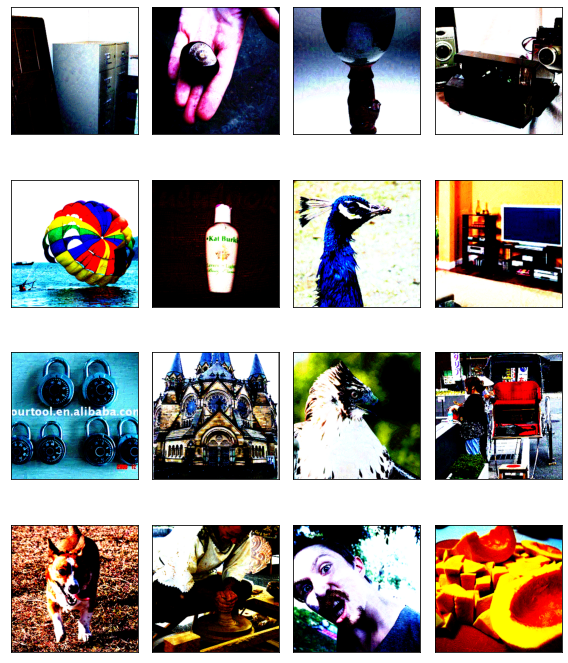

In [27]:
# show some adv examples
cnt = 0
plt.figure(figsize=(8,10))
for i in range(4):
    for j in range(4):
        cnt += 1
        plt.subplot(4, 4,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        img = advs[i*4+j][1][0].cpu().permute(1,2,0)
        plt.imshow(img, cmap="gray")
plt.tight_layout()
plt.show()

In [28]:
torch.save(advs, 'advs.pt')